In [1]:
import requests
from bs4 import BeautifulSoup
import pandas  as  pd
import matplotlib.pyplot as plt

In [2]:
url = "https://repositorio.lamolina.edu.pe/recent-submissions?offset="

# Realizar una petición HTTP a la URL
response = requests.get(url)

# Analizar el contenido HTML de la página usando Beautiful Soup
soup = BeautifulSoup(response.content, "html.parser")

# Crea el limite superior del for tomando en cuenta la cantidad de tesis expuestas en  la pagina
# insertar int((soup.find("p",{"class":"pagination-info"})).text[-4:]) en numtesis para extraer todas las tesis
canttesis=int((soup.find("p",{"class":"pagination-info"})).text[-4:])
limsup=canttesis/20+1

In [3]:
hrefs=[]
# Iterar sobre todos los valores de i desde 0 hasta 100
for i in range(0, int(limsup)):
    # Crear la URL de la página a scrappear
    url = "https://repositorio.lamolina.edu.pe/recent-submissions?offset=" + str(i*20)

    # Realizar una petición HTTP a la URL
    response = requests.get(url)

    # Analizar el contenido HTML de la página usando Beautiful Soup
    soup = BeautifulSoup(response.content, "html.parser")

    # Extraer todos los enlaces de la página
    links = soup.find_all("h4",{"class":"artifact-title"})


    # Iterar sobre todos los enlaces extraídos y mostrarlos por pantalla
    for link in links:
        hrefs.append("https://repositorio.lamolina.edu.pe"+link.find("a").get("href")+"?show=full")

In [4]:
# Se declaran las listas donde se almacenaran los datos
institucion=[]
titulo=[]
autor=[]
grado=[]
asesor=[]
resumen=[]
anio=[]
disciplina=[]
vacio=""

In [5]:
for i in range(len(hrefs)):
    response=requests.get(hrefs[i])
    
    # Analizar el contenido HTML de la página usando Beautiful Soup
    soup = BeautifulSoup(response.content, "html.parser")

    # Extraer la tabla que deseas
    table = soup.find("table", {"class": "ds-includeSet-table detailtable table table-striped table-hover"})

    # Convertir la tabla en un DataFrame de Pandas
    df = pd.read_html(str(table),index_col=0)[0]
    
    # Nos quedamos con la parte de la tabla que nos importa
    df=df[:][1]
    
    # Scrappeo de datos
    institucion.append(df.get("dc.publisher", vacio))   
    titulo.append(df.get("dc.title", vacio))
    anio.append(df.get("dc.date.issued", vacio))
    if "thesis.degree.discipline" in df:
        if type(df["thesis.degree.discipline"])==float:
            disciplina.append(vacio)
        else:
            if isinstance(df["thesis.degree.discipline"], str) :
                disciplina.append(df["thesis.degree.discipline"])
            else :
                disciplina.append(df["thesis.degree.discipline"][:].apply(lambda x: x).tolist())     
    else:
        disciplina.append(vacio)
    if "dc.type" in df:
        if type(df["dc.type"])==float:
            grado.append(vacio)
        else:
            if isinstance(df["dc.type"], str) :
                grado.append(df["dc.type"])
            else :
                grado.append(df["dc.type"][:].apply(lambda x: x).tolist())     
    else:
        grado.append(vacio)
    if "dc.contributor.author" in df:
        if type(df["dc.contributor.author"])==float:
            autor.append(vacio)
        else:
            if isinstance(df["dc.contributor.author"], str) :
                autor.append(df["dc.contributor.author"])
            else :
                autor.append(df["dc.contributor.author"][:].apply(lambda x: x).tolist())     
    else:
        autor.append(vacio)
        
    if "dc.contributor.advisor" in df:
        if type(df["dc.contributor.advisor"])==float :
            asesor.append(vacio)
        else:
            if isinstance(df["dc.contributor.advisor"], str) :
                asesor.append(df["dc.contributor.advisor"]) 
            else :
                asesor.append(df["dc.contributor.advisor"].apply(lambda x: x).tolist())
    else:
        asesor.append(vacio)
    
    if "dc.description.abstract" in df:
        if type(df["dc.description.abstract"])==float :
            resumen.append(vacio)
        else:
            if isinstance(df["dc.description.abstract"], str):
                resumen.append(df["dc.description.abstract"])
            else:
                resumen.append(df["dc.description.abstract"][0])
    else:
        resumen.append(vacio)

In [6]:
# Para solo quedarnos con el año en caso se haya ingresado la fecha completa
anio = [str(x)[:4] for x in anio]

# Para que donde se tenga una lista de asesores se coloque un string con ambos asesores con un espacio de por medio
for i, elemento in enumerate(disciplina):
    if isinstance(elemento, list):
        disciplina[i] = "\n".join(elemento)

# Para que donde se tenga una lista de asesores se coloque un string con ambos asesores con un espacio de por medio
for i, elemento in enumerate(grado):
    if isinstance(elemento, list):
        grado[i] = "\n".join(elemento)

# Para que donde se tenga una lista de asesores se coloque un string con ambos asesores con un espacio de por medio
for i, elemento in enumerate(asesor):
    if isinstance(elemento, list):
        asesor[i] = "\n".join(elemento)
        
# Para que donde se tenga una lista de autores se coloque un string con ambos autores con un espacio de por medio
for i, elemento in enumerate(autor):
    if isinstance(elemento, list):
        autor[i] = "\n".join(elemento)
        
# Para reemplazar los grados que salen en la web por un formato mas legible
dicgrado={'info:eu-repo/semantics/bachelorThesis':"Bachillerato",
          'info:eu-repo/semantics/doctoralThesis':"Doctorado",
          'info:eu-repo/semantics/masterThesis':"Maestria",
          'T_D_Bélgica':"Doctorado",
          'T_D_Manejo Forestal':"Doctorado",
          'T_M_Manejo Forestal':"Maestria",
          'info:eu-repo/semantics/article':"Articulo",
          'info:eu-repo/semantics/book':"Libro",
          'info:eu-repo/semantics/bookPart':"Libro",
          'info:eu-repo/semantics/conferenceObject':"Conferencia"}
for i, valor in enumerate(grado):
    if valor in dicgrado:
        grado[i] = dicgrado[valor]

In [7]:
datospreexportar = pd.DataFrame(list(zip(anio,institucion,titulo,autor,grado,asesor,resumen,disciplina)),columns =["Año","Institución","Titulo","Autor","Grado","Asesor","Resumen","Disciplina"])

In [16]:
datospreexportar.fillna("")
datospreexportar.dropna()

,Año,Institución,Titulo,Autor,Grado,Asesor,Resumen,Disciplina
0,2022,Universidad Nacional Agraria La Molina,Validación de un procedimiento de limpieza y d...,"Ramirez Pulce, Jessica Lizeth",Bachillerato,"Nolazco Cama, Diana M.",En la industria de alimentos los procesos de l...,Industrias Alimentarias
1,2022,Universidad Nacional Agraria La Molina,Producción de Melón Hale's Best Jumbo en respu...,"Palomino Bravo, Enrique Alejandro",Bachillerato,"Hurtado Leo, Lorenzo Miguel",De diciembre del 2017 a abril del 2018 se eval...,Agronomía
2,2022,Universidad Nacional Agraria La Molina,Evaluación de la incorporación presupuestal de...,"Castillo Tito, Claudia Ximena",Bachillerato,"Diez Matallana, Ramón Alberto",El OEFA (Organismo de Evaluación y Fiscalizaci...,Economía y Planificación
3,2022,Universidad Nacional Agraria La Molina,Construcción de dique de tierra en la Qocha Ac...,"Cárdenas Alegre, Gian Lucca",Bachillerato,"Vásquez Villanueva, Absalón",En el presente trabajo se aplicó los criterios...,Ingeniería Agrícola
4,2022,Universidad Nacional Agraria La Molina,Mejora del flujo de procesos en las diferentes...,"De la Cruz Cárdenas, Estefany Lilian",Bachillerato,"Enciso Gutiérrez, Antonio Celestino",El cambio climático en estos últimos tiempos h...,Ingeniería Agrícola
...,...,...,...,...,...,...,...,...
4108,2007,Universidad Nacional Agraria La Molina,"Preservación con sales CCB y CCA-C, durabilida...","Guerrero Ruíz, William Omar",Bachillerato,"Trujillo Cuéllar, Florencio Teodoro",La motivación de este trabajo de tesis ha sido...,Industrias Forestales
4109,2007,Universidad Nacional Agraria La Molina,Influencia de la densidad de la madera en la c...,"Santillán Saldaña, Tatiana Silvana",Bachillerato,"Canchucaja Rojas, Julio César",Las industrias de tableros de partículas son u...,Industrias Forestales
4110,2007,Universidad Nacional Agraria La Molina,Caracterización de las propiedades tintóreas d...,"Masias Brocker, Katia",Bachillerato,"Gonzáles Mora, Héctor Enrique",En los últimos años se observa un incremento e...,Industrias Forestales
4111,2006,Universidad Nacional Agraria La Molina,"Propiedades físico-mecánicas del Aliso, Alnus ...","López Fierro, Jorge Eduardo",Bachillerato,"Acevedo Mallque, Moisés Pascual","El distrito de Chalaco, ubicado en la provinci...",Industrias Forestales


In [17]:
datosexportar=datospreexportar[datospreexportar["Disciplina"].str.contains("Estadística|Informática", case=False)]

In [18]:
datosexportar.to_csv("repositorio_agraria_tesis.csv", sep=',')

In [19]:
datosexportar

,Año,Institución,Titulo,Autor,Grado,Asesor,Resumen,Disciplina
5,2022,Universidad Nacional Agraria La Molina,Predicción del siniestro de vehículos particul...,"Ramirez Navarro, Vanessa Judith",Bachillerato,"Chue Gallardo, Jorge",Tras el incremento de siniestros vehiculares d...,Estadística e Informática
91,2022,Universidad Nacional Agraria La Molina,Identificación de clientes en campañas para un...,"Alvarez Chancasanampa, Julio César",Bachillerato,"Miranda Villagómez, Clodomiro Fernando","La presente investigación, tiene como objetivo...",Estadística e Informática
104,2022,Universidad Nacional Agraria La Molina,Clasificación de la eficiencia del gasto públi...,"Romero Cuadros, Italo Brayan",Maestria,"Gamboa Unsihhuay, Jesús Eduardo",Esta investigación tiene como objetivo de dete...,Estadística Aplicada
295,2022,Universidad Nacional Agraria La Molina,Implementación de una solución de business int...,"Tinco Curi, Elizabeth Irene",Bachillerato,"Soto Rodríguez, Iván Dennys",Actualmente el sector salud dispone de una gra...,Estadística e Informática
297,2020,Universidad Nacional Agraria La Molina,Identificación de clientes que realizaron fuga...,"Marquez Meza, Francisco",Bachillerato,"Chue Gallardo, Jorge",El presente trabajo tiene como objetivo ilustr...,Estadística e Informática
...,...,...,...,...,...,...,...,...
3357,2015,Universidad Nacional Agraria La Molina,Una aplicación del modelo de regresión lineal ...,"Loarte Laos, Paul Antonio",T_en proceso,"López de Castilla Vásquez, Carlos",El presente trabajo de investigación tiene com...,Estadística e Informática
3529,2015,Universidad Nacional Agraria La Molina,Uso del criterio AHP para la toma de decisiones,"Loaiza Alamo, Marco Antonio",Bachillerato,"Sotomayor Ruíz, Rino Nicanor",El objetivo de esta investigación es determina...,Estadística e Informática
3733,1980,Universidad Nacional Agraria La Molina,Muestreo de unidades agrícolas a través de pun...,"Alarcón Novoa, Jorge Alfonso",Bachillerato,"Rubio Donet, Arturo",En esta investigación se presenta un método de...,Estadística e Informática
3788,2015,Universidad Nacional Agraria La Molina,Aplicación de redes neuronales y regresión log...,"Muñoz Muñoz, Emanuel Guillermo",Maestria,"Chue Gallardo, Jorge",El propósito de este trabajo es presentar y ap...,Estadística Aplicada


# Graficos

In [20]:
# Proporcion que representan las tesis de estadistica en el total de tesis
proporcion= str(round((datosexportar.shape[0]/canttesis)*100,5))
print(proporcion+"%")

1.99368%


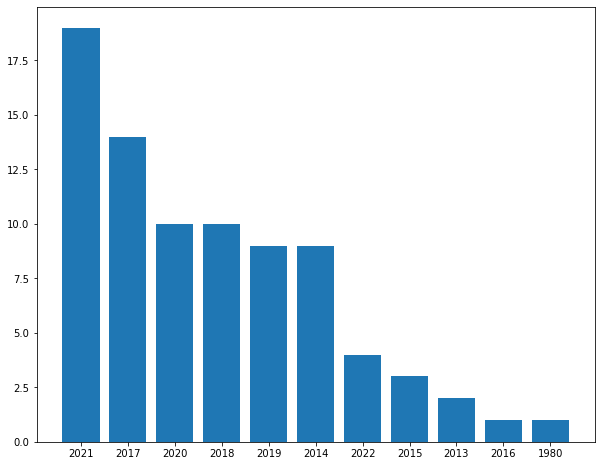

In [21]:
countanios = datosexportar['Año'].value_counts()
# Obtener las etiquetas (años) y los valores (cantidades) de la serie de conteos
etiquetas = countanios.index 
valores = countanios.values

# Crear una figura de 10x8 pulgadas
plt.figure(figsize=(10, 8))

# Crear el gráfico de barras
plt.bar(etiquetas, valores)

# Mostrar el gráfico
plt.show()

In [23]:
# Estadisticas de los años
aniosdata=datosexportar[["Grado","Año"]].groupby(["Año"]).count()
aniosdata.describe()

,Grado
count,11.000000
mean,7.454545
std,5.820028
min,1.000000
25%,2.500000
50%,9.000000
75%,10.000000
max,19.000000


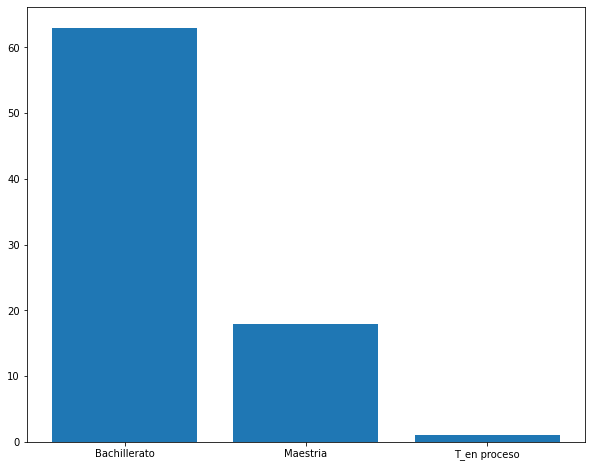

In [24]:
countgrados = datosexportar['Grado'].value_counts()
# Obtener las etiquetas (años) y los valores (cantidades) de la serie de conteos
etiquetas = countgrados.index 
valores = countgrados.values

# Crear una figura de 10x8 pulgadas
plt.figure(figsize=(10, 8))

# Crear el gráfico de barras
plt.bar(etiquetas, valores)

# Mostrar el gráfico
plt.show()